## 1. Importation des bibliothèques

In [638]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

## 2. Génération du Dataset

Création d'un dataset synthétique avec 2 features pour la visualisation.

In [639]:
SEED = 42            # seed pour reproductibilité
RANDOMIZE = True     # mettre False pour résultat fixe
TEST_SIZE = 0.2
CENTERS = 2
CLUSTER_STD = 1.5    # augmenter pour plus de chevauchement
NOISE_STD = 0.35     # bruit ajouté aux features
LABEL_NOISE = 0.05   # proportion de labels inversés

# Générateur aléatoire
rs = np.random.RandomState(None if RANDOMIZE else SEED)

# Données de base
X, y = make_blobs(
    n_samples=400,
    n_features=2,
    centers=CENTERS,
    cluster_std=CLUSTER_STD,
    random_state=rs,
)

# Bruit sur les features
X = X + rs.normal(0, NOISE_STD, size=X.shape)

# Bruit sur les labels
if LABEL_NOISE > 0:
    m = len(y)
    n_flip = int(LABEL_NOISE * m)
    idx = rs.choice(m, n_flip, replace=False)
    y[idx] = 1 - y[idx]

y = y.reshape(-1, 1)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=rs, shuffle=True
)

print(f"Forme de X: {X.shape} | y: {y.shape}")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Forme de X: (400, 2) | y: (400, 1)
Train: (320, 2), Test: (80, 2)


### Visualisation du dataset

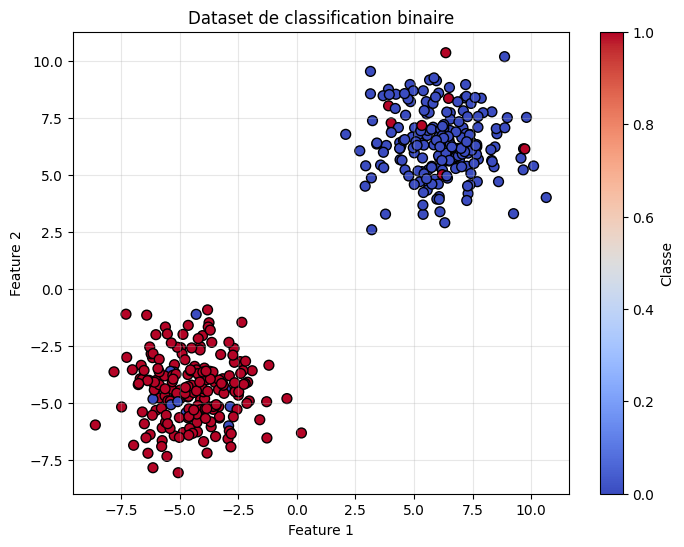

In [640]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap='coolwarm', edgecolors='k', s=50)
plt.title("Dataset de classification binaire")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Classe')
plt.grid(True, alpha=0.3)
plt.show()

## 3. Fonctions du modèle

### 3.1 Initialisation des paramètres

## Théorie Mathématique du Perceptron

### Notation
- $X$ : matrice des données d'entrée de dimension $(m, n)$ où $m$ = nombre d'exemples, $n$ = nombre de features
- $y$ : vecteur des étiquettes réelles de dimension $(m, 1)$
- $\theta$ : vecteur des poids de dimension $(n, 1)$
- $b$ : biais (scalaire)
- $\alpha$ : taux d'apprentissage (learning rate)
- $\hat{y}$ : prédictions du modèle

In [641]:
def initialiser_parametres(n_features):
    """
    Initialise les poids et le biais
    """
    theta = np.random.randn(n_features, 1) * 0.01
    b = 0.0
    return theta, b

### 3.2 Fonction d'activation (Sigmoïde)

In [642]:
def sigmoid(z):
    """
    Fonction sigmoïde: σ(z) = 1 / (1 + e^(-z))
    """
    return 1 / (1 + np.exp(-z))

### Explication : Fonction Sigmoïde

La sigmoïde transforme toute valeur réelle en probabilité entre 0 et 1 :

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

**Propriétés :**
- Quand $z \to \infty$, $\sigma(z) \to 1$
- Quand $z \to -\infty$, $\sigma(z) \to 0$
- Quand $z = 0$, $\sigma(z) = 0.5$
- Dérivée : $\sigma'(z) = \sigma(z)(1 - \sigma(z))$

### Explication : Initialisation des paramètres
Les poids $\theta$ sont initialisés aléatoirement avec une petite valeur pour éviter une convergence lente. Le biais $b$ est initialisé à 0.

$$\theta \sim \mathcal{N}(0, 0.01) \quad \text{(distribution normale)}$$
$$b = 0$$

### 3.3 Fonction de coût (Log Loss)

In [643]:
def calculer_cout(X, y, theta, b):
    """
    Calcule la fonction de coût (Log Loss)
    J(θ,b) = -1/m * Σ[y*log(ŷ) + (1-y)*log(1-ŷ)]
    """
    m = X.shape[0]
    z = X.dot(theta) + b
    A = sigmoid(z)
    
    # Éviter log(0)
    epsilon = 1e-8
    A = np.clip(A, epsilon, 1 - epsilon)
    
    cout = -1/m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    return cout

### Explication : Fonction de Coût (Log Loss)

La fonction de coût mesure l'erreur entre les prédictions et les vraies valeurs :

$$J(\theta, b) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \right]$$

**Explication :**
- Si $y = 1$ et $\hat{y} \approx 1$, alors $\log(\hat{y}) \approx 0$ (coût faible) ✓
- Si $y = 1$ et $\hat{y} \approx 0$, alors $\log(\hat{y}) \to -\infty$ (coût très élevé) ✗
- La moyenne sur $m$ exemples garantit que le coût est indépendant de la taille du dataset

### 3.4 Calcul des gradients

In [644]:
def calculer_gradients(X, y, theta, b):
    """
    Calcule les gradients de θ et b
    """
    m = X.shape[0]
    z = X.dot(theta) + b
    A = sigmoid(z)
    
    dtheta = 1/m * X.T.dot(A - y)
    db = 1/m * np.sum(A - y)
    
    return dtheta, db

### Explication : Calcul des Gradients

Les gradients indiquent la direction et la magnitude du changement nécessaire pour minimiser le coût.

**Gradient par rapport aux poids :**
$$\frac{\partial J}{\partial \theta} = \frac{1}{m} X^T (\hat{y} - y)$$

**Gradient par rapport au biais :**
$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})$$

**Interprétation :**
- $(\hat{y} - y)$ = erreur de prédiction (différence entre prédiction et vraie valeur)
- Les gradients sont multipliés par les features $X$ pour adapter l'apprentissage selon l'importance de chaque feature

## 4. Algorithme de Gradient Descent

In [645]:
def gradient_descent(X, y, theta, b, learning_rate=0.1, n_iterations=1000):
    """
    Entraîne le modèle avec la descente de gradient
    """
    historique_couts = []
    
    for i in range(n_iterations):
        # Calcul des gradients
        dtheta, db = calculer_gradients(X, y, theta, b)
        
        # Mise à jour des paramètres
        theta = theta - learning_rate * dtheta
        b = b - learning_rate * db
        
        # Enregistrement du coût
        cout = calculer_cout(X, y, theta, b)
        historique_couts.append(cout)
        
        # Affichage tous les 100 itérations
        if i % 100 == 0:
            print(f"Itération {i}: Coût = {cout:.4f}")
    
    return theta, b, historique_couts

### Explication : Descente de Gradient (Gradient Descent)

La descente de gradient met à jour les paramètres de manière itérative pour minimiser le coût.

**Règles de mise à jour :**
$$\theta := \theta - \alpha \frac{\partial J}{\partial \theta}$$
$$b := b - \alpha \frac{\partial J}{\partial b}$$

**Interprétation :**
- On **soustrait** le gradient (direction opposée) pour aller vers le minimum
- Le taux d'apprentissage $\alpha$ contrôle la **taille des pas** :
  - $\alpha$ petit = convergence lente mais stable
  - $\alpha$ grand = convergence rapide mais risque de divergence
- Après chaque itération, le coût devrait diminuer

## 5. Entraînement du modèle

In [646]:
# Initialisation
theta, b = initialiser_parametres(X_train.shape[1])

# Entraînement sur le train uniquement
theta_final, b_final, historique_couts = gradient_descent(
    X_train, y_train, theta, b,
    learning_rate=0.1,
    n_iterations=1000
)

print(f"\nEntraînement terminé!")
print(f"Coût final (train): {historique_couts[-1]:.4f}")

Itération 0: Coût = 0.2269
Itération 100: Coût = 0.2204
Itération 200: Coût = 0.2190
Itération 300: Coût = 0.2186
Itération 400: Coût = 0.2184
Itération 500: Coût = 0.2184
Itération 600: Coût = 0.2183
Itération 700: Coût = 0.2183
Itération 800: Coût = 0.2183
Itération 900: Coût = 0.2183

Entraînement terminé!
Coût final (train): 0.2183


## 6. Courbe d'apprentissage (Loss vs Epochs)

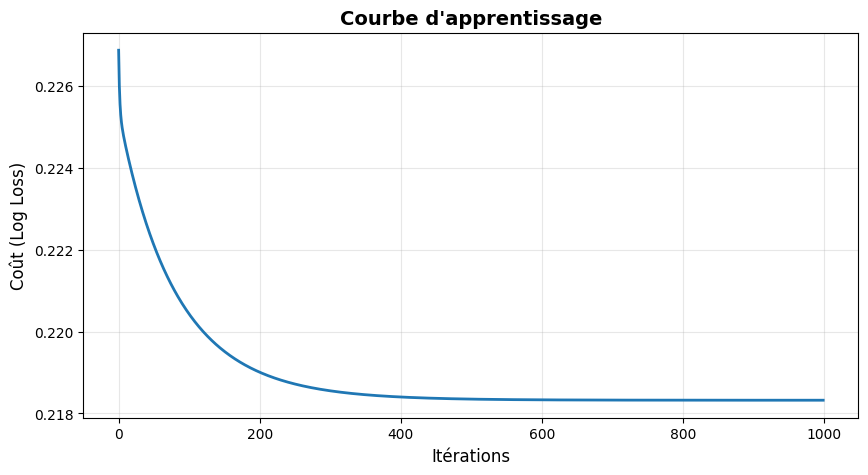

In [647]:
plt.figure(figsize=(10, 5))
plt.plot(historique_couts, linewidth=2)
plt.title("Courbe d'apprentissage", fontsize=14, fontweight='bold')
plt.xlabel("Itérations", fontsize=12)
plt.ylabel("Coût (Log Loss)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

### Explication : Prédictions et Seuil de Classification

Pour obtenir une classe binaire (0 ou 1) à partir de la probabilité, on utilise un seuil de 0.5 :

$$\text{Prédiction} = \begin{cases} 
1 & \text{si } \sigma(z) \geq 0.5 \\
0 & \text{sinon}
\end{cases}$$

**Note :** 
- Cela est équivalent à vérifier si $z = \theta^T X + b \geq 0$
- La frontière de décision est l'hyperplan où $z = 0$, soit : $\theta_1 x_1 + \theta_2 x_2 + b = 0$

## 7. Fonction de prédiction

In [648]:
def predire(X, theta, b):
    """
    Effectue des prédictions sur les données X
    """
    z = X.dot(theta) + b
    A = sigmoid(z)
    predictions = (A >= 0.5).astype(int)
    return predictions

## 8. Calcul de l'Accuracy

In [649]:
# Prédictions sur train et test
predictions_train = predire(X_train, theta_final, b_final)
predictions_test = predire(X_test, theta_final, b_final)

# Accuracy
accuracy_train = np.mean(predictions_train == y_train) * 100
accuracy_test = np.mean(predictions_test == y_test) * 100

print(f"Accuracy train : {accuracy_train:.2f}%")
print(f"Accuracy test  : {accuracy_test:.2f}%")

Accuracy train : 94.69%
Accuracy test  : 96.25%


## 9. Prédictions sur de nouvelles données

In [650]:
# Nouvelles données de test (ne pas écraser `X_test` du split)
X_nouveaux = np.array([
    [0.5, 1.0],
    [-1.5, -2.0],
    [2.0, 3.0],
    [-3.0, 1.0]
])

# Prédictions
predictions_nouveaux = predire(X_nouveaux, theta_final, b_final)

print("Prédictions sur de nouvelles données:\n")
for i, (point, pred) in enumerate(zip(X_nouveaux, predictions_nouveaux)):
    print(f"Point {i+1}: {point} → Classe prédite: {pred[0]}")


Prédictions sur de nouvelles données:

Point 1: [0.5 1. ] → Classe prédite: 1
Point 2: [-1.5 -2. ] → Classe prédite: 1
Point 3: [2. 3.] → Classe prédite: 0
Point 4: [-3.  1.] → Classe prédite: 1


## 10. Visualisation de la frontière de décision

/var/folders/93/271sd8y92c5clnmhjk4rpmy00000gn/T/ipykernel_57813/1901448490.py:19: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.ravel(), cmap='coolwarm', edgecolors='k', s=70, marker='x', label='Test')


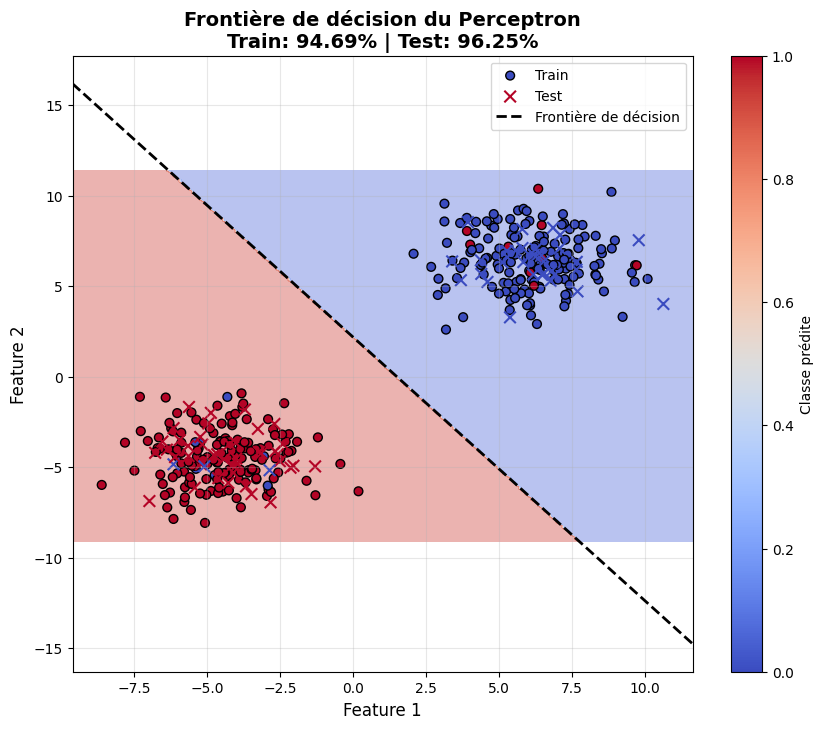

In [651]:
# Création d'une grille pour la frontière de décision
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 200),
    np.linspace(x2_min, x2_max, 200)
)

# Prédictions sur la grille
grilletab = np.c_[xx1.ravel(), xx2.ravel()]
Z = predire(grilletab, theta_final, b_final)
Z = Z.reshape(xx1.shape)

# Visualisation
plt.figure(figsize=(10, 8))
plt.contourf(xx1, xx2, Z, alpha=0.4, cmap='coolwarm')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), cmap='coolwarm', edgecolors='k', s=40, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.ravel(), cmap='coolwarm', edgecolors='k', s=70, marker='x', label='Test')

# Ligne de décision (θ1*x1 + θ2*x2 + b = 0)
x1_line = np.linspace(x1_min, x1_max, 100)
x2_line = -(theta_final[0][0] * x1_line + b_final) / theta_final[1][0]
plt.plot(x1_line, x2_line, 'k--', linewidth=2, label='Frontière de décision')

title = (
    f"Frontière de décision du Perceptron\n"
    f"Train: {accuracy_train:.2f}% | Test: {accuracy_test:.2f}%"
)
plt.title(title, fontsize=14, fontweight='bold')
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.colorbar(label='Classe prédite')
plt.show()

## Conclusion

Le Perceptron entraîné avec Gradient Descent a réussi à classifier les données avec une bonne accuracy. La frontière de décision linéaire sépare efficacement les deux classes.